In [ ]:
!nvidia-smi

Thu Aug 29 01:26:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install gitpython>=3.1.30
!pip install matplotlib>=3.3
!pip install numpy>=1.23.5
!pip install opencv-python>=4.1.1
!pip install pillow>=10.3.0
!pip install psutil  # system resources
!pip install PyYAML>=5.3.1
!pip install requests>=2.32.0
!pip install scipy>=1.4.1
!pip install thop>=0.1.1  # FLOPs computation
!pip install torch>=1.8.0  # see https://pytorch.org/get-started/locally (recommended)
!pip install torchvision>=0.9.0
!pip install tqdm>=4.64.0
!pip install ultralytics>=8.2.34  # https://ultralytics.com

In [ ]:
!git clone https://github.com/NVIDIA/apex && cd apex && pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" . --user && cd .. && rm -rf apex

Cloning into 'apex'...
remote: Enumerating objects: 11837, done.
remote: Counting objects: 100% (3930/3930), done.
remote: Compressing objects: 100% (712/712), done.
remote: Total 11837 (delta 3475), reused 3407 (delta 3212), pack-reused 7907 (from 1)
Receiving objects: 100% (11837/11837), 15.58 MiB | 13.42 MiB/s, done.
Resolving deltas: 100% (8277/8277), done.
Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
DEPRECATION: --build-option and --global-option are deprecated. pip 24.2 will enforce this behaviour change. A possible replacement is to use --config-settings. Discussion can be found at https://github.com/pypa/pip/issues/11859
Processing /content/apex
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-9o849bmw
  Entered build tracker: /tmp/pip-build-tracker-9o849bmw
  Cr

In [ ]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import json
import urllib.request
import PIL.Image as Image
import cv2
import torch
import torchvision
from IPython.display import display
from sklearn.model_selection import train_test_split
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10
np.random.seed(42)

In [ ]:
##Read annotations available on the json file, every line contains an object, splitting it into lines
masks = []
with open("/content/drive/MyDrive/ML/Projects/5_Personality_Detection/combined_annotations.json") as f:
    for line in f:
        masks.append(json.loads(line))

In [ ]:
masks[0]

{'content': '/content/drive/MyDrive/ML/Projects/5_Personality_Detection/images/maksssksksss0.png',
 'annotation': [{'label': ['without_mask'],
   'notes': '',
   'points': [{'x': 0.154296875, 'y': 0.28688524590163933},
    {'x': 0.212890625, 'y': 0.3879781420765027}],
   'imageWidth': 512,
   'imageHeight': 366},
  {'label': ['with_mask'],
   'notes': '',
   'points': [{'x': 0.361328125, 'y': 0.273224043715847},
    {'x': 0.44140625, 'y': 0.39344262295081966}],
   'imageWidth': 512,
   'imageHeight': 366},
  {'label': ['without_mask'],
   'notes': '',
   'points': [{'x': 0.634765625, 'y': 0.2459016393442623},
    {'x': 0.703125, 'y': 0.38524590163934425}],
   'imageWidth': 512,
   'imageHeight': 366}],
 'extras': None}

In [ ]:
categories = []
for c in masks:
  for a in c['annotation']:
    categories.extend(a['label'])
categories = list(set(categories))
categories.sort()
categories

['mask_weared_incorrect', 'with_mask', 'without_mask']

In [ ]:
train_masks, val_masks = train_test_split(masks, test_size=0.15)
len(train_masks), len(val_masks)

(725, 128)

In [ ]:
row = train_masks[25]
img = Image.open(row["content"])
img = img.convert('RGB')
img.save("demo_image.jpeg", "JPEG")

In [ ]:
row


{'content': '/content/drive/MyDrive/ML/Projects/5_Personality_Detection/images/maksssksksss448.png',
 'annotation': [{'label': ['with_mask'],
   'notes': '',
   'points': [{'x': 0.705, 'y': 0.18055555555555555},
    {'x': 0.8025, 'y': 0.3888888888888889}],
   'imageWidth': 400,
   'imageHeight': 216},
  {'label': ['with_mask'],
   'notes': '',
   'points': [{'x': 0.575, 'y': 0.1574074074074074},
    {'x': 0.66, 'y': 0.3194444444444444}],
   'imageWidth': 400,
   'imageHeight': 216},
  {'label': ['with_mask'],
   'notes': '',
   'points': [{'x': 0.485, 'y': 0.2777777777777778},
    {'x': 0.58, 'y': 0.4675925925925926}],
   'imageWidth': 400,
   'imageHeight': 216},
  {'label': ['with_mask'],
   'notes': '',
   'points': [{'x': 0.2475, 'y': 0.23148148148148148},
    {'x': 0.375, 'y': 0.4583333333333333}],
   'imageWidth': 400,
   'imageHeight': 216}],
 'extras': None}

In [ ]:
img = cv2.cvtColor(cv2.imread(f'demo_image.jpeg'), cv2.COLOR_BGR2RGB)
img.shape

(216, 400, 3)

In [ ]:
for a in row['annotation']:
  for label in a['label']:
    w = a['imageWidth']
    h = a['imageHeight']
    points = a['points']
    p1, p2 = points
    x1, y1 = p1['x'] * w, p1['y'] * h
    x2, y2 = p2['x'] * w, p2['y'] * h
    cv2.rectangle(
      img,
      (int(x1), int(y1)),
      (int(x2), int(y2)),
      color=(0, 255, 0),
      thickness=2
    )
    ((label_width, label_height), _) = cv2.getTextSize(
        label,
        fontFace=cv2.FONT_HERSHEY_PLAIN,
        fontScale=1.75,
        thickness=1
    )
    cv2.rectangle(
      img,
      (int(x1), int(y1)),
      (int(x1 + 2), int(y1 +2)),
      color=(0, 255, 0),
      thickness=1
    )
    cv2.putText(
      img,
      label,
      org=(int(x1), int(y1)), # bottom left
      fontFace=cv2.FONT_HERSHEY_PLAIN,
      fontScale=0.5,
      color=(255, 255, 255),
      thickness=1
    )

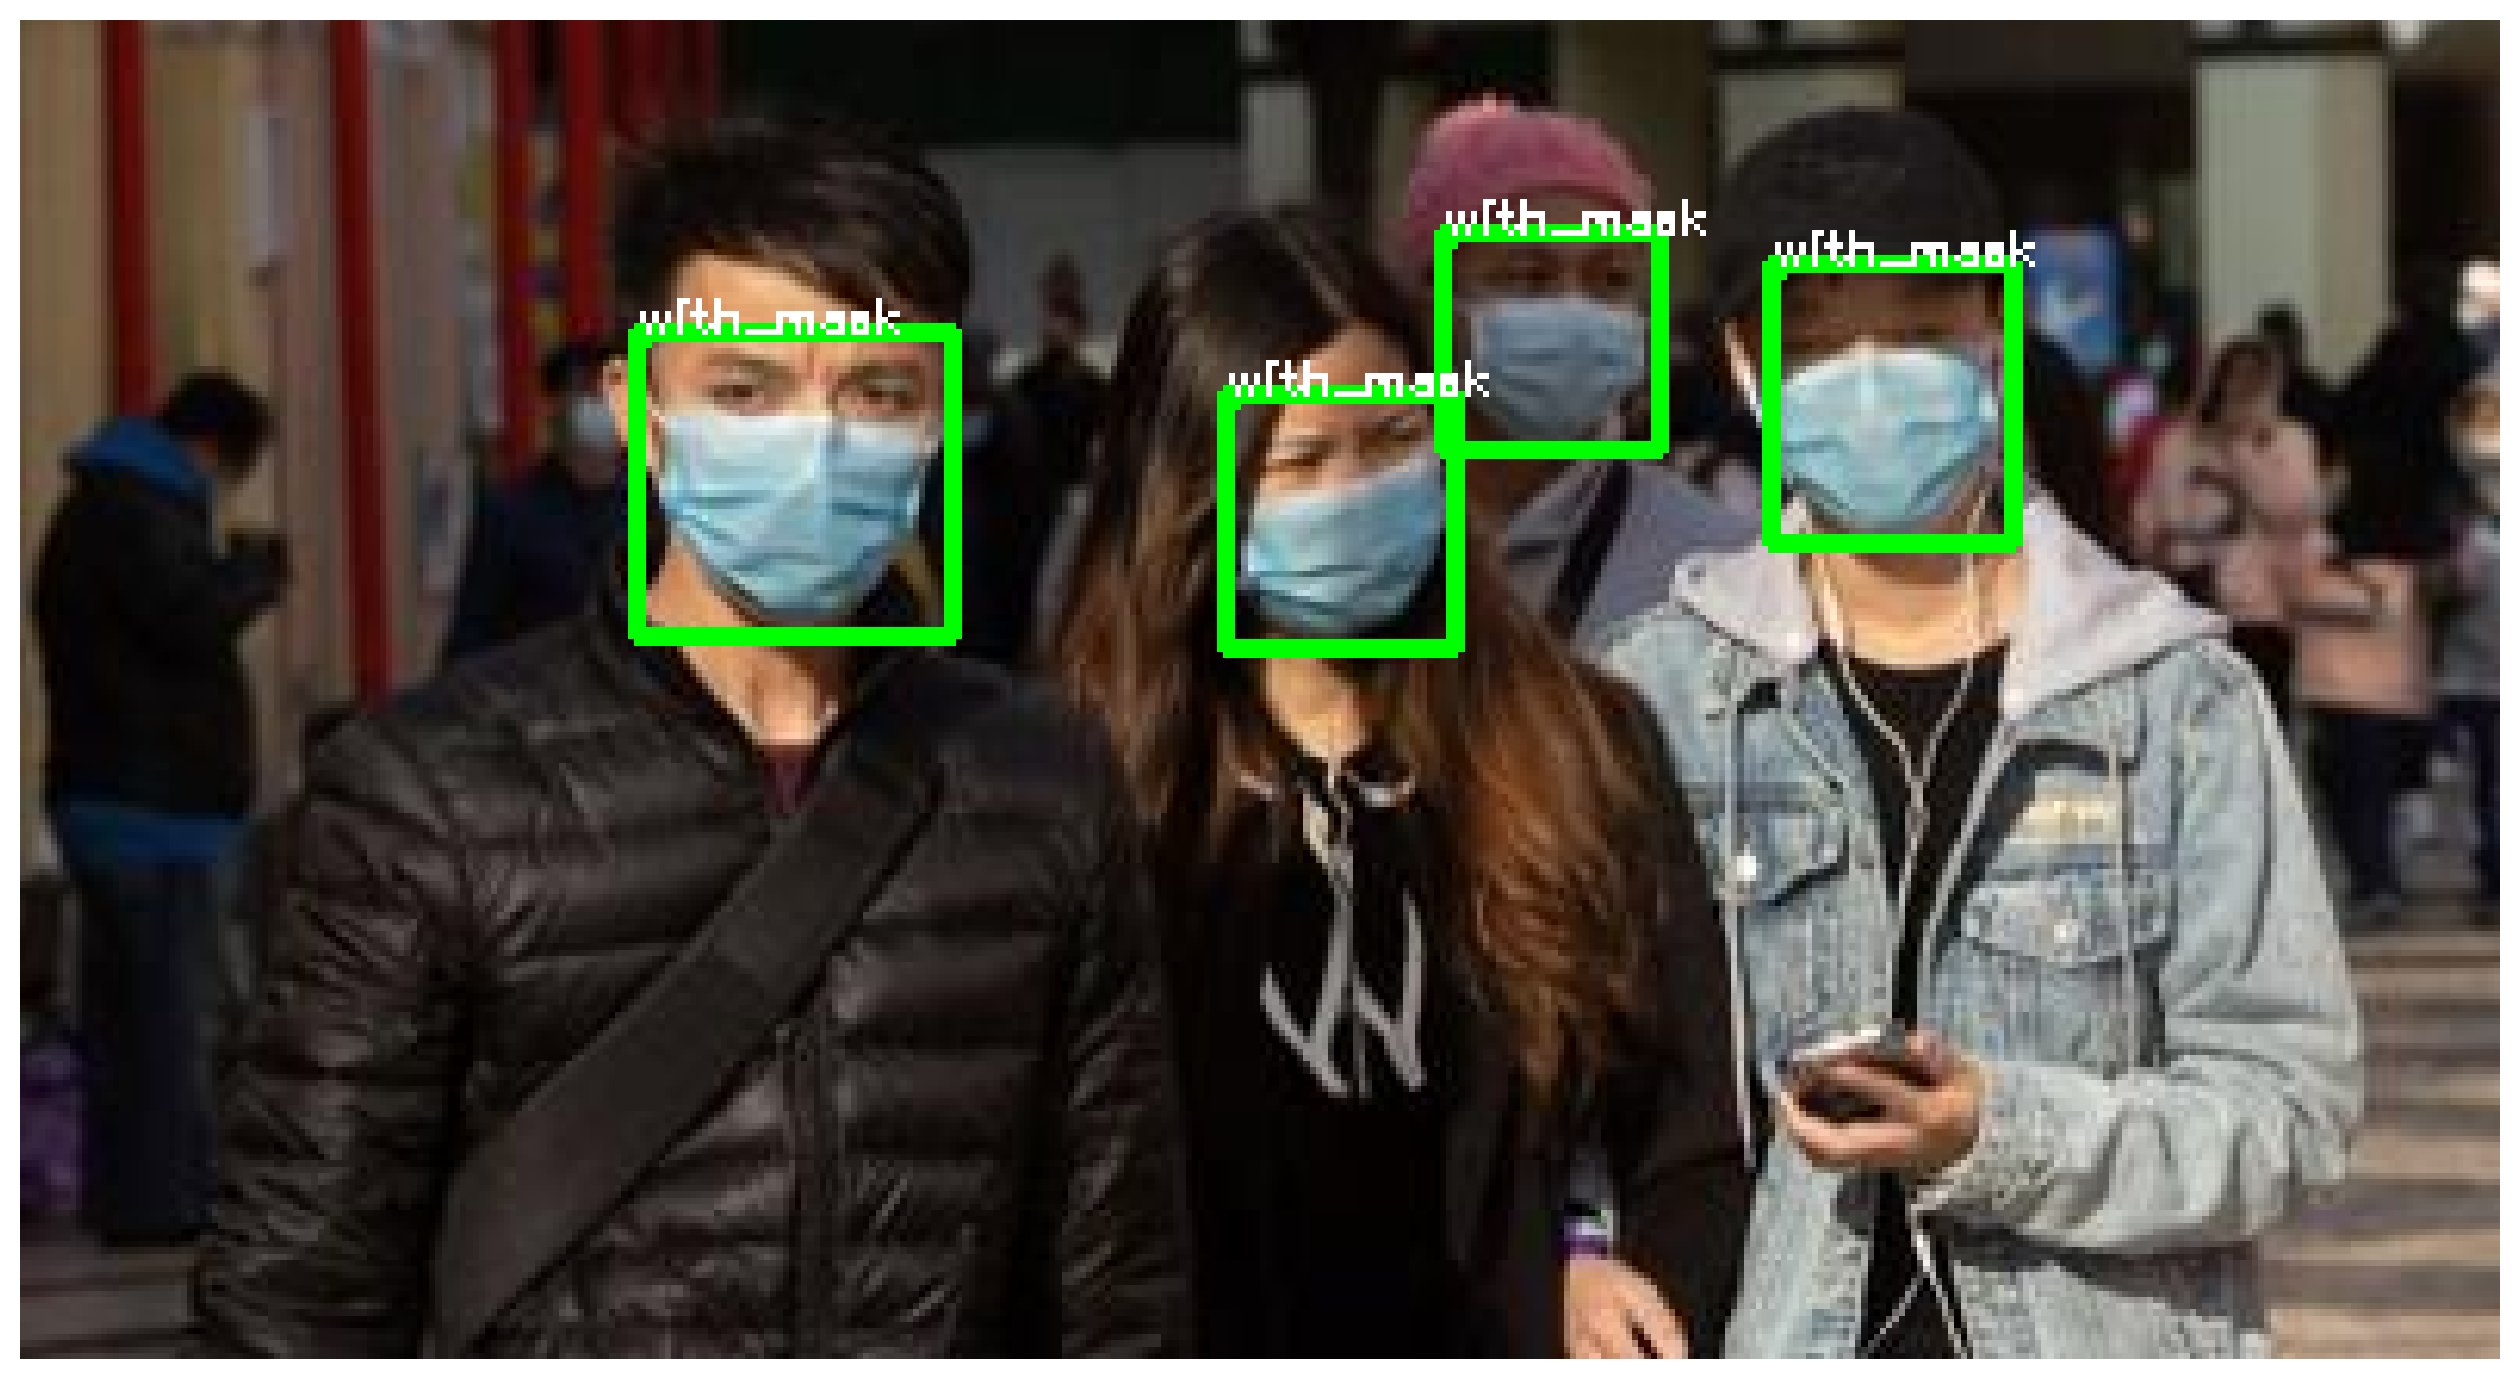

In [ ]:
plt.imshow(img)
plt.axis('off');

In [ ]:
def create_dataset(masks, categories, dataset_type):
  images_path = Path(f"masks/images/{dataset_type}")
  images_path.mkdir(parents=True, exist_ok=True)
  labels_path = Path(f"masks/labels/{dataset_type}")
  labels_path.mkdir(parents=True, exist_ok=True)
  for img_id, row in enumerate(tqdm(masks)):
    image_name = f"{img_id}.jpeg"
    img = Image.open(row["content"])
    img = img.convert("RGB")
    img.save(str(images_path / image_name), "JPEG")
    label_name = f"{img_id}.txt"
    with (labels_path / label_name).open(mode="w") as label_file:
      for a in row['annotation']:
        for label in a['label']:
          category_idx = categories.index(label)
          points = a['points']
          p1, p2 = points
          x1, y1 = p1['x'], p1['y']
          x2, y2 = p2['x'], p2['y']
          bbox_width = x2 - x1
          bbox_height = y2 - y1
          label_file.write(
            f"{category_idx} {x1 + bbox_width / 2} {y1 + bbox_height / 2} {bbox_width} {bbox_height}\n"
          )

In [ ]:
create_dataset(train_masks, categories, 'train')
create_dataset(val_masks, categories, 'val')

100%|██████████| 128/128 [00:53<00:00,  2.40it/s]


In [ ]:
!sudo apt-get install tree -qq > /dev/null

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [ ]:
!tree masks -L 2

masks
├── images
│   ├── train
│   └── val
└── labels
    ├── train
    └── val

6 directories, 0 files


In [ ]:
!cat masks/labels/train/0.txt

2 0.27875 0.08399999999999999 0.04249999999999998 0.096
1 0.52 0.102 0.050000000000000044 0.08399999999999999
1 0.58375 0.396 0.04749999999999999 0.08000000000000002
1 0.7075 0.176 0.05499999999999994 0.088


##FineTuning YOLO v5

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16927, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 16927 (delta 62), reused 87 (delta 48), pack-reused 16805 (from 1)
Receiving objects: 100% (16927/16927), 15.68 MiB | 27.17 MiB/s, done.
Resolving deltas: 100% (11600/11600), done.
/content/yolov5


In [ ]:
!gdown --id 1xuGbUKC4ljL4S9xpxGxTPF_Gv3PjqqmO -O data/masks.yaml
!gdown --id 1BjgdaQENeQGGBtOUGHLi8DbaVn63-rRb -O models/yolov5x.yaml

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1xuGbUKC4ljL4S9xpxGxTPF_Gv3PjqqmO
To: /content/yolov5/data/masks.yaml
100% 128/128 [00:00<00:00, 731kB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1BjgdaQENeQGGBtOUGHLi8DbaVn63-rRb
To: /content/yolov5/models/yolov5x.yaml
100% 1.42k/1.42k [00:00<00:00, 6.22MB/s]


In [ ]:
!python train.py --img 640 --batch 4 --epochs 5 \
  --data ./data/masks.yaml --cfg ./models/yolov5x.yaml --weights yolov5x.pt \
  --name yolov5x_masks --cache

2024-08-29 01:36:36.094855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 01:36:36.114828: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 01:36:36.120736: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5x.pt, cfg=./models/yolov5x.yaml, data=./data/masks.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=4, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=Fals

In [ ]:
from utils.plots import plot_results

s = plot_results("/content/yolov5/runs/train/yolov5x_masks3/results.csv")  # plot 'results.csv' as 'results.png'
s

In [ ]:
!find ../masks/images/val/ -maxdepth 1 -type f | head -50 | xargs cp -t "./inference/images/"


In [ ]:
!python detect.py --weights /content/yolov5/runs/train/yolov5x_masks3/weights/best.pt \
  --img 640 --conf 0.4 --source ./inference/images/

detect: weights=['/content/yolov5/runs/train/yolov5x_masks3/weights/best.pt'], source=./inference/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-362-ge8a30cf8 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86186872 parameters, 0 gradients, 203.8 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/50 /content/yolov5/inference/images/0.jpeg: 448x640 12 with_masks, 77.1ms
image 2/50 /content/yolov5/inference/images/1.jpeg: 384x640 7 with_masks, 1 without_mask, 38.0ms
image 3/50 /content/yolov5/inference/images/100.jpeg: 640x448 2